# Experiment results
---------------------
In this short notebook, I will demonstrate the power of the SVD for approximating the gradient.

## Introduction
In this notebook, I will briefly introduce an algorithm for optimizing machine learning models across multiple GPUs. Then I will compare performance on CIFAR-10 using 2/4/8 V100 GPUs.

First, recall the gradient descent algorithm
```
1. input <- x
2. output <- model(x)
3. loss <- loss_fn(output)
3. grad <- model.params.gradient
4. model.params <- model.params - learning_rate * grad
5. GOTO 1 # (perhaps choosing a different sample x, stopping when the accuracy is suitably nice)
```
and assuming that each model parameter comes in the form of an m by n matrix (or other suitable tensor) we make the following modification

```
3.' grad <- LOW_RANK_APPROXIMATION(model.params.gradient)
```
Usually, our LOW_RANK_APPROXIMATION function is obtained from the singular value decomposition.
For example, if $\mathrm{grad} = U \cdot \Sigma \cdot V^*$ then we take $\mathrm{grad} \sim U[:rank] \cdot \Sigma[:rank] \cdot V[:rank]^*$ where rank is hopefully small relative to the size of grad.

Actually, this would be too slow so we instead use the 'randomized_svd' function from the [Tensorly](tensorly.org) library. This is an implementation of Algorithm 5.1 from ['Finding structure with randomness: Probabilistic algorithms for constructing matrix decompositions](https://arxiv.org/abs/0909.4061).

Please also note the similarity to [GaLORE](https://arxiv.org/abs/2403.03507), but in principal these are two separate algorithms with separate goals.

## Motivation
This algorithm was originally developed as a submission to the AlgoPerf machine learning competition. Following up on my submission to the competition, I wanted to demonstrate the scaling potential of my algorithm as the number of GPUs change.
Please understand that development is ongoing especially as my resources are quite limited.

## The data
The data I have collected was generated from running my algorithm on the CIFAR-10 dataset using the [AlgoPerf](https://github.com/mlcommons/algorithmic-efficiency) library.

### Import modules and load data

In [ ]:
import os
using_colab = 'COLAB_GPU' in os.environ
if using_colab:
    ! git clone https://github.com/davidtweedle/low-rank-approximation.git

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
momentum_8gpu = pd.read_csv("data/momentum_8gpu/momentum_8gpu_eval_measurements.csv")
momentum_4gpu = pd.read_csv("data/momentum_4gpu/momentum_4gpu_eval_measurements.csv")
momentum_2gpu = pd.read_csv("data/momentum_2gpu/momentum_2gpu_eval_measurements.csv")
nadamw_8gpu = pd.read_csv("data/nadamw_8gpu/nadamw_8gpu_eval_measurements.csv")
nadamw_4gpu = pd.read_csv("data/nadamw_4gpu/nadamw_4gpu_eval_measurements.csv")
nadamw_2gpu = pd.read_csv("data/nadamw_2gpu/nadamw_2gpu_eval_measurements.csv")
baseline_8gpu = pd.read_csv("data/baseline_8gpu/baseline_8gpu_eval_measurements.csv")
baseline_4gpu = pd.read_csv("data/baseline_4gpu/baseline_4gpu_eval_measurements.csv")
baseline_2gpu = pd.read_csv("data/baseline_2gpu/baseline_2gpu_eval_measurements.csv")
baseline_8gpu_largebatch = pd.read_csv("data/baseline_8gpu_largebatch/eval_measurements.csv")
baseline_8gpu_4x_batch = pd.read_csv("data/baseline_8gpu_4x_batch/eval_measurements.csv")
baseline_8gpu_8x_batch = pd.read_csv("data/baseline_8gpu_8x_batch/eval_measurements.csv")
baseline_8gpu_8x_batch_lr_2 = pd.read_csv("data/baseline_8gpu_8x_batch_lr_2/eval_measurements.csv")
baseline_8gpu_8x_batch_lr2_again = pd.read_csv("data/baseline_8gpu_8x_batch_lr2_again/eval_measurements.csv")
momentum_8gpu_8x = pd.read_csv("data/momentum_8gpu_8x/eval_measurements.csv")
momentum_8gpu_largebatch = pd.read_csv("data/momentum_8gpu_largebatch/eval_measurements.csv")

In [3]:
## Clean up data
momentum_8gpu = momentum_8gpu[momentum_8gpu['global_step'] % 352 == 0]
momentum_4gpu = momentum_4gpu[momentum_4gpu['global_step'] % 352 == 0]
momentum_2gpu = momentum_2gpu[momentum_2gpu['global_step'] % 352 == 0]
momentum_4gpu = momentum_4gpu[:200]
baseline_8gpu = baseline_8gpu[baseline_8gpu['global_step'] % 352 == 0]
baseline_4gpu = baseline_4gpu[baseline_4gpu['global_step'] % 352 == 0]
baseline_2gpu = baseline_2gpu[baseline_2gpu['global_step'] % 352 == 0]
nadamw_8gpu = nadamw_8gpu[nadamw_8gpu['global_step'] % 352 == 0]
nadamw_4gpu = nadamw_4gpu[nadamw_4gpu['global_step'] % 352 == 0]
nadamw_2gpu = nadamw_2gpu[nadamw_2gpu['global_step'] % 352 == 0]

In [4]:
baseline_8gpu.tail()

,accumulated_eval_time,accumulated_logging_time,accumulated_submission_time,global_step,preemption_count,score,test/accuracy,test/loss,test/num_examples,total_duration,train/accuracy,train/loss,validation/accuracy,validation/loss,validation/num_examples
21,31.211504,3.188954,1999.547118,7392,0,1999.547118,0.9360,0.271984,10000,2052.580204,1.00000,0.000410,0.9422,0.260664,5000
22,32.108799,3.353178,2096.684310,7744,0,2096.684310,0.9376,0.261541,10000,2151.658623,1.00000,0.000294,0.9384,0.256949,5000
23,32.988005,3.509701,2192.761497,8096,0,2192.761497,0.9406,0.253172,10000,2249.621098,1.00000,0.000263,0.9404,0.253630,5000
24,33.886555,3.665440,2287.919711,8448,0,2287.919711,0.9399,0.248450,10000,2346.702717,1.00000,0.000275,0.9424,0.248049,5000
25,34.781349,3.815916,2384.845422,8800,0,2384.845422,0.9385,0.248114,10000,2445.541348,0.97793,0.264509,0.9434,0.245005,5000


### Comparisons

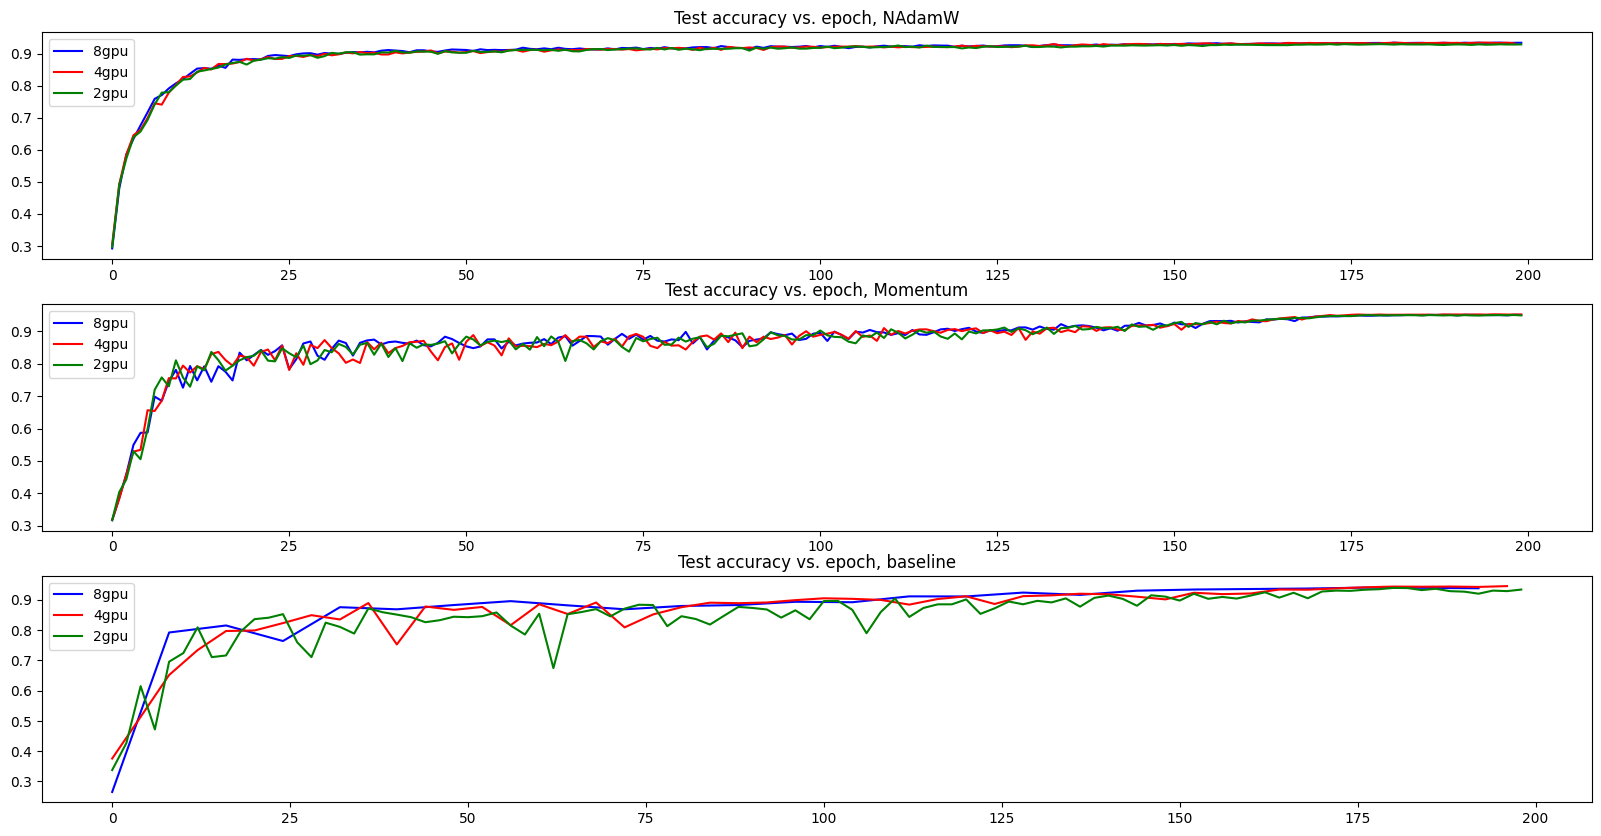

In [21]:
## First observe performance as gpu's increase
## by epoch
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(20,10))
ax1.set_title("Test accuracy vs. epoch, NAdamW")
ax1.plot(range(200), nadamw_8gpu['test/accuracy'],'b-', label='8gpu')
ax1.plot(range(199), nadamw_4gpu['test/accuracy'], 'r-', label='4gpu')
ax1.plot(range(200), nadamw_2gpu['test/accuracy'], 'g-', label='2gpu')
ax1.legend()
# performance by epoch is unchanged
ax2.set_title("Test accuracy vs. epoch, Momentum")
ax2.plot(range(200), momentum_8gpu['test/accuracy'],'b-', label='8gpu')
ax2.plot(range(200), momentum_4gpu['test/accuracy'], 'r-', label='4gpu')
ax2.plot(range(200), momentum_2gpu['test/accuracy'], 'g-', label='2gpu')
ax2.legend()
# performance by epoch is unchanged
ax3.set_title("Test accuracy vs. epoch, Low rank gradient approximation")
ax3.plot([8 * i for i in range(25)], baseline_8gpu['test/accuracy'], 'b-', label='8gpu')
ax3.plot([4 * i for i in range(50)], baseline_4gpu['test/accuracy'], 'r-', label='4gpu')
ax3.plot([2 * i for i in range(100)], baseline_2gpu['test/accuracy'], 'g-', label='2gpu')
ax3.legend()

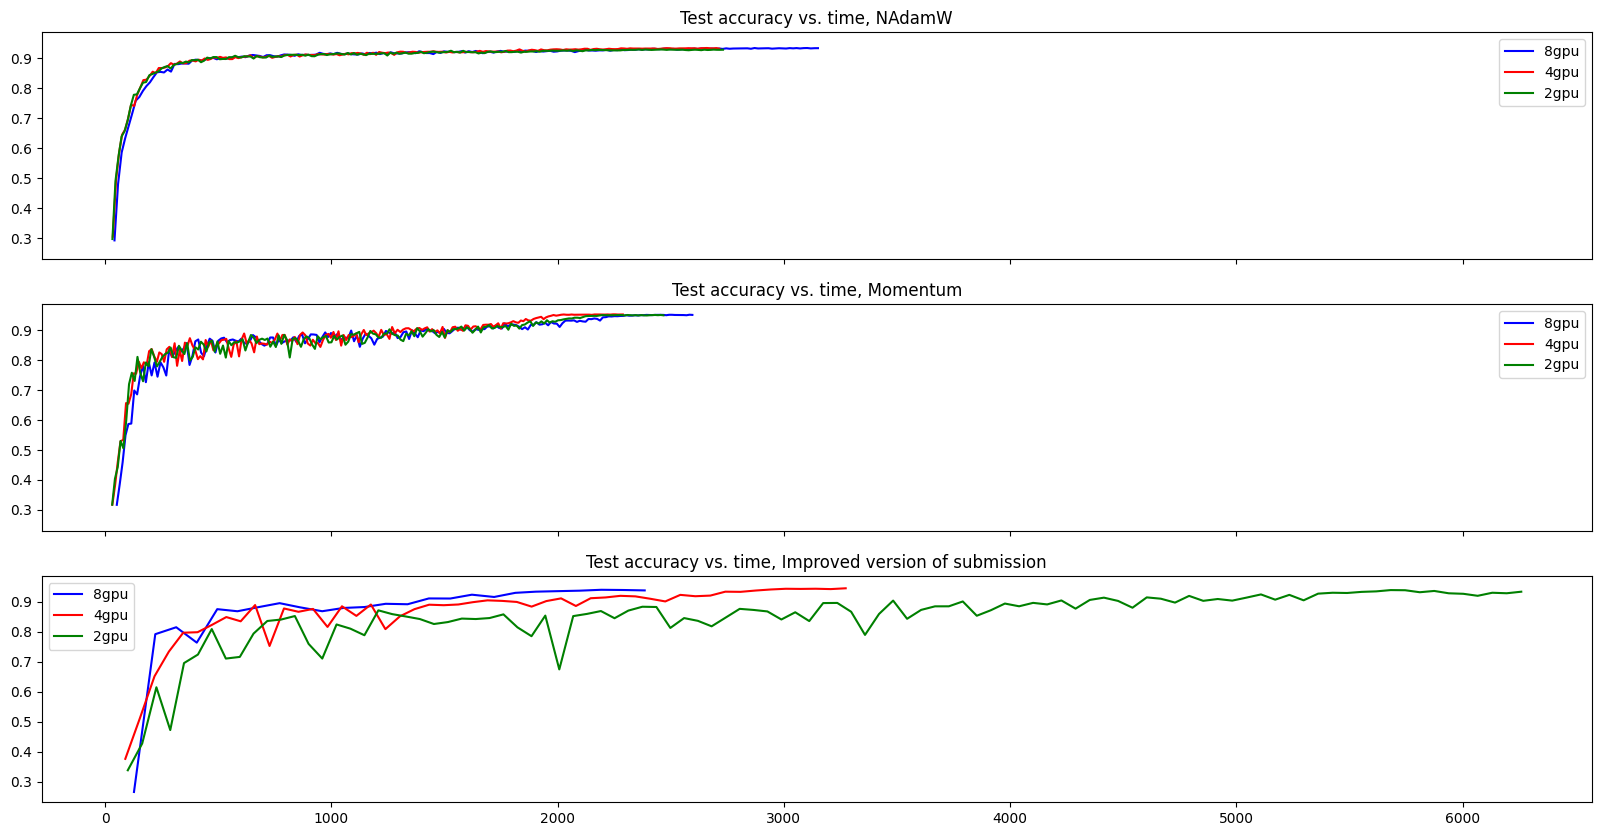

In [22]:
## observe performance by time
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(20,10), sharex=True, sharey=True)
ax1.set_title("Test accuracy vs. time, NAdamW")
ax1.plot(nadamw_8gpu['accumulated_submission_time'],nadamw_8gpu['test/accuracy'],'b-', label='8gpu')
ax1.plot(nadamw_4gpu['accumulated_submission_time'], nadamw_4gpu['test/accuracy'], 'r-', label='4gpu')
ax1.plot(nadamw_2gpu['accumulated_submission_time'], nadamw_2gpu['test/accuracy'], 'g-', label='2gpu')
ax1.legend()
# performance by epoch is unchanged
ax2.set_title("Test accuracy vs. time, Momentum")
ax2.plot(momentum_8gpu['accumulated_submission_time'], momentum_8gpu['test/accuracy'],'b-', label='8gpu')
ax2.plot(momentum_4gpu['accumulated_submission_time'], momentum_4gpu['test/accuracy'], 'r-', label='4gpu')
ax2.plot(momentum_2gpu['accumulated_submission_time'], momentum_2gpu['test/accuracy'], 'g-', label='2gpu')
ax2.legend()
# performance by epoch is unchanged
ax3.set_title("Test accuracy vs. time, Low rank gradient approximation")
ax3.plot(baseline_8gpu['accumulated_submission_time'], baseline_8gpu['test/accuracy'], 'b-', label='8gpu')
ax3.plot(baseline_4gpu['accumulated_submission_time'], baseline_4gpu['test/accuracy'], 'r-', label='4gpu')
ax3.plot(baseline_2gpu['accumulated_submission_time'], baseline_2gpu['test/accuracy'], 'g-', label='2gpu')
ax3.legend()


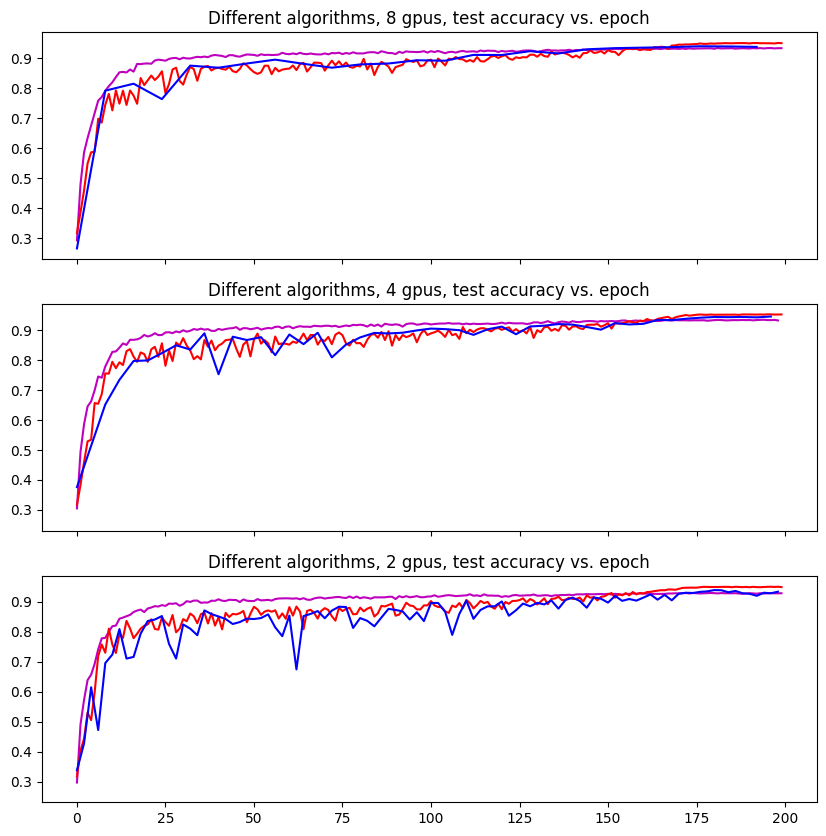

In [11]:
## compare 4 algorithms by fixing N_GPUS
## compare by epoch
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10,10), sharex=True, sharey=True)
ax1.set_title("Different algorithms, 8 gpus, test accuracy vs. epoch")
ax1.plot(range(200), nadamw_8gpu['test/accuracy'], 'm-', label='nadamw')
ax1.plot(range(200), momentum_8gpu['test/accuracy'], 'r-', label='momentum')
ax1.plot([8 * i for i in range(25)], baseline_8gpu['test/accuracy'], 'b-',label='Low rank gradient approximation')
ax1.legend()
ax2.set_title("Different algorithms, 4 gpus, test accuracy vs. epoch")
ax2.plot(range(199), nadamw_4gpu['test/accuracy'], 'm-', label='nadamw')
ax2.plot(range(200), momentum_4gpu['test/accuracy'], 'r-', label='momentum')
ax2.plot([4 * i for i in range(50)], baseline_4gpu['test/accuracy'], 'b-', label='Low rank gradient approximation')
ax2.legend()
ax3.set_title("Different algorithms, 2 gpus, test accuracy vs. epoch")
ax3.plot(range(200), nadamw_2gpu['test/accuracy'], 'm-', label='nadamw')
ax3.plot(range(200), momentum_2gpu['test/accuracy'], 'r-', label='momentum')
ax3.plot([2 * i for i in range(100)], baseline_2gpu['test/accuracy'], 'b-', label='Low rank gradient approximation')
ax3.legend()

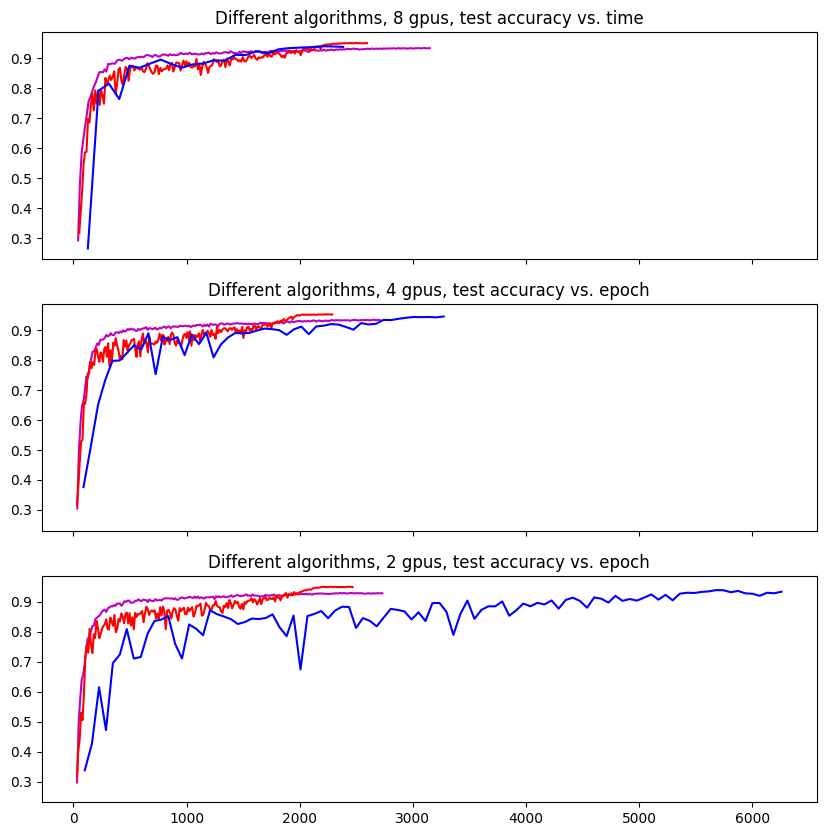

In [12]:
## compare by time
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10,10), sharex=True, sharey=True)
ax1.set_title("Different algorithms, 8 gpus, test accuracy vs. time")
ax1.plot(nadamw_8gpu['accumulated_submission_time'], nadamw_8gpu['test/accuracy'], 'm-',label='nadamw')
ax1.plot(momentum_8gpu['accumulated_submission_time'], momentum_8gpu['test/accuracy'], 'r-', label='momentum')
ax1.plot(baseline_8gpu['accumulated_submission_time'], baseline_8gpu['test/accuracy'], 'b-', label='Low rank gradient approximation')
ax1.legend()
ax2.set_title("Different algorithms, 4 gpus, test accuracy vs. epoch")
ax2.plot(nadamw_4gpu['accumulated_submission_time'], nadamw_4gpu['test/accuracy'], 'm-', label='nadamw')
ax2.plot(momentum_4gpu['accumulated_submission_time'], momentum_4gpu['test/accuracy'], 'r-', label='momentum')
ax2.plot(baseline_4gpu['accumulated_submission_time'], baseline_4gpu['test/accuracy'], 'b-', label='Low rank gradient approximation')
ax2.legend()
ax3.set_title("Different algorithms, 2 gpus, test accuracy vs. epoch")
ax3.plot(nadamw_2gpu['accumulated_submission_time'], nadamw_2gpu['test/accuracy'], 'm-', label='nadamw')
ax3.plot(momentum_2gpu['accumulated_submission_time'], momentum_2gpu['test/accuracy'], 'r-', label='momentum')
ax3.plot(baseline_2gpu['accumulated_submission_time'], baseline_2gpu['test/accuracy'], 'b-', label='Low rank gradient approximation')
ax3.legend()

### About the algorithms
  - baseline - Same as momentum, but before all reducing the gradient, simply replace the gradient with a low rank approximation. We use the 'randomized_svd' algorithm from the tensorly package. This is straight from the paper Algorithm 5.1 in ['Finding structure with randomness: Probabilistic algorithms for constructing matrix decompositions](https://arxiv.org/abs/0909.4061)
  - nadamw - nadamw algorithm taken from the [AlgoPerf benchmark](https://github.com/mlcommons/algorithmic-efficiency)
  - momentum - momentum algorithm taken from the [AlgoPerf benchmark](https://github.com/mlcommons/algorithmic-efficiency)

### Preliminary results on large batch sizes
From the below plots, we see that the previously good performance of our SVD approximation adjustments are outperformed by momentum.
Note that this is on a batch size of 8192.
But notice that our method takes a lot longer to warmup than momentum.
So it may be that more careful control of the learning rate is required here.
We hope that with more investigation and experimentation, we are able to push the limits of our algorithm and develop some rules of thumb for the hyperparameters and learning rates.

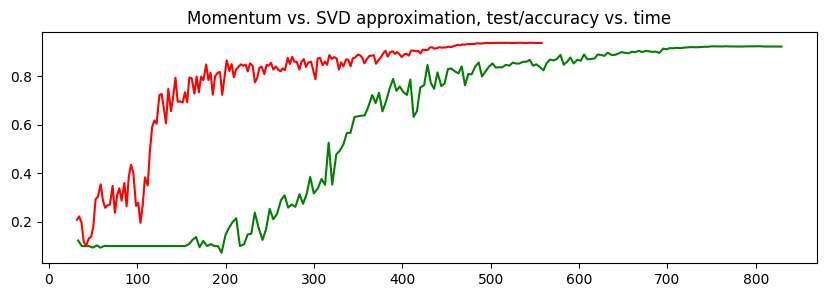

In [17]:
fig, ax = plt.subplots(figsize=(10,3))
ax.set_title("Momentum vs. SVD approximation, test/accuracy vs. time")
ax.plot(baseline_8gpu_8x_batch_lr2_again['accumulated_submission_time'],baseline_8gpu_8x_batch_lr2_again['test/accuracy'],'g-', label='Low rank gradient approximation')
ax.plot(momentum_8gpu_8x['accumulated_submission_time'],momentum_8gpu_8x['test/accuracy'],'r-', label='momentum')
ax.legend()

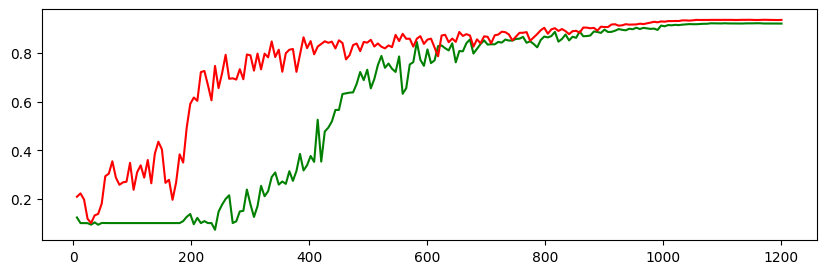

In [18]:
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(baseline_8gpu_8x_batch_lr2_again['global_step'],baseline_8gpu_8x_batch_lr2_again['test/accuracy'],'g-', label='Low rank gradient approximation')
ax.plot(momentum_8gpu_8x['global_step'],momentum_8gpu_8x['test/accuracy'],'r-', label='momentum')
ax.legend()

### Further investigations
- Perform the same experiment on different data sets, we hope to try tiny-imagenet next.
- We need to carefully choose a learning rate scheduler which is complementary to our algorithm
- There is also a need to understand the best choice of hyperparameters